In [1]:
from quickdb.datarake2 import master
from tqdm import tqdm

### helper functions

In [2]:
def getbody(func):
    import inspect
    return '\n'.join(inspect.getsource(func).split('\n')[1:])

In [3]:
import contextlib

@contextlib.contextmanager
def progress_bar():
    with tqdm(total=1, ncols=120) as pbar:
        def progress(p):
            pbar.total = p.total
            pbar.n = p.done
            pbar.refresh()
        yield progress

### 1D histogram

100%|█████████████████████████████████████████████████████████████████████████████████| 128/128 [00:01<00:00, 95.23it/s]


CPU times: user 295 ms, sys: 68.1 ms, total: 363 ms
Wall time: 1.34 s


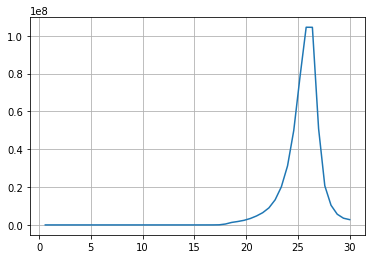

In [26]:
def make_env():
    import numpy

    rerun = 'pdr2_wide'

    def flux2mag(flux):
         return -2.5 * numpy.log10(flux * (10**-9) / 3631.)

    def mapper(patch):
        mag = flux2mag(patch('forced.i.psfflux_flux'))
        return numpy.histogram(mag, bins=50, range=(0, 30))

    def reducer(a, b):
        return a[0] + b[0], a[1]

with progress_bar() as progress:
    %time result = master.run_make_env(getbody(make_env), {}, progress)

%matplotlib inline
from matplotlib import pyplot

hist, bins = result
pyplot.plot(bins[1:], hist)
pyplot.grid()

### 2D histogram

100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:01<00:00, 122.97it/s]


CPU times: user 271 ms, sys: 69.4 ms, total: 341 ms
Wall time: 1.04 s


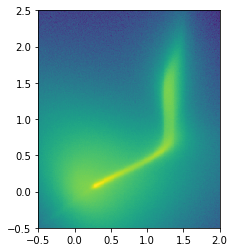

In [28]:
def make_env():
    import numpy

    rerun = 'pdr2_wide'

    def flux2mag(flux):
         return -2.5 * numpy.log10(flux * (10**-9) / 3631.)

    def mapper(patch):
        patch = patch[patch('forced.i.extendedness_value') < 0.5]
        g = flux2mag(patch('forced.g.psfflux_flux'))
        r = flux2mag(patch('forced.r.psfflux_flux'))
        i = flux2mag(patch('forced.i.psfflux_flux'))
        return numpy.histogram2d(g - r, r - i, bins=(200, 400), range=((-0.5, 2), (-0.5, 2.5)))

    def reducer(a, b):
        return a[0] + b[0], a[1], a[2]

with progress_bar() as progress:
    %time result = master.run_make_env(getbody(make_env), {}, progress)

import numpy

hist, xedges, yedges = result
pyplot.imshow(numpy.log(1 + hist).T, origin='low', extent=(xedges[0], xedges[-1], yedges[0], yedges[-1]))

### SQL interface

In [9]:
from quickdb.sql2mapreduce import run_sql

In [30]:
sql = '''
    SELECT
        COUNT(*) + COUNT(*) - 2 * COUNT(*)
    FROM
        pdr2_wide
    GROUP BY
        forced.isprimary
'''

with progress_bar() as progress:
    %time result = run_sql(sql, master.run_make_env, progress=progress)


from collections import OrderedDict
import pandas

pandas.DataFrame.from_dict(OrderedDict(zip(result.target_names, result.target_list)))

100%|████████████████████████████████████████████████████████████████████████████████| 384/384 [00:01<00:00, 335.40it/s]

CPU times: user 639 ms, sys: 178 ms, total: 817 ms
Wall time: 1.14 s


,$group_by,col0
0,"(False,)",0
1,"(True,)",0


In [29]:
sql = '''
    SELECT
        object_id
    FROM
        pdr2_wide
    WHERE
        forced.isprimary AND object_id % 2
    ORDER
        BY object_id
    LIMIT
        100
'''

with progress_bar() as progress:
    %time result = run_sql(sql, master.run_make_env, progress=progress)


from collections import OrderedDict
import pandas

pandas.DataFrame.from_dict(OrderedDict(zip(result.target_names, result.target_list)))

100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:00<00:00, 252.80it/s]

CPU times: user 213 ms, sys: 75.3 ms, total: 289 ms
Wall time: 503 ms


,col0
0,36407037608853547
1,36407037608853559
2,36407037608853581
3,36407037608853589
4,36407037608853597
...,...
95,36407325371662419
96,36407325371662425
97,36407325371662427
98,36407325371662429
